# Predicting Voting Method in Union County NC in the 2020 General Election

<font size=3rem>
    
- **[Introduction](#Introduction)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[INTERPRET](#INTERPRET)**<br>
- **[Conclusions/Recommendations](#Conclusions/Recommendations)<br>**
</font>

# Introduction

# OBTAIN

In [1]:
## Import Numpy and set random seed for notebook
import numpy as np
np.random.seed(319)

In [2]:
## Import functions made specifically for this project
from capstone_functions import *

In [3]:
## Import remaining necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tzlocal import get_localzone

In [4]:
## Set options for displaying Pandas DataFrames
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

In [5]:
## Import and preview dataset
elec_df = pd.read_csv('Data/UC_gen_2020.zip')
elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,vote_early,vote_by_mail,vote_curbside,Pri_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv
0,EF230133,0,46.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,UNA,M,1974,2019-04-25,W,NL,28173.0,4009 MILLBRIDGE PKWY,WAXHAW,OC,Y,020A,020A,9.0,35.0,68.0,2.0
1,EF231096,0,46.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,DEM,F,1974,2019-06-24,A,NL,28173.0,4009 MILLBRIDGE PKWY,WAXHAW,OC,Y,020A,020A,9.0,35.0,68.0,2.0
2,AL261840,1,26.0,NaN,No Vote,0.0,0.0,0.0,No Vote,UNA,F,1994,2013-11-04,W,NL,28079.0,1001 STEVENS PRIDE CT,INDIAN TRAIL,IA,Y,029A,029A,9.0,35.0,68.0,3.0
3,AL178177,0,62.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,UNA,M,1958,2014-09-17,W,UN,28079.0,1001 STEVENS PRIDE CT,INDIAN TRAIL,OK,Y,029A,029A,9.0,35.0,68.0,3.0
4,AL193958,0,62.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,No Vote,REP,F,1958,2013-07-24,W,NL,28079.0,1001 STEVENS PRIDE CT,INDIAN TRAIL,PA,Y,029A,029A,9.0,35.0,68.0,3.0


# SCRUB

In [6]:
## Check df metadata
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168463 entries, 0 to 168462
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ncid                168463 non-null  object 
 1   no_vote_his         168463 non-null  int64  
 2   birth_age_adj       168463 non-null  float64
 3   voting_method       131414 non-null  object 
 4   Gen_2020            168463 non-null  object 
 5   vote_early          168463 non-null  float64
 6   vote_by_mail        168463 non-null  float64
 7   vote_curbside       168463 non-null  float64
 8   Pri_2020            168463 non-null  object 
 9   party_cd            168463 non-null  object 
 10  gender_code         168463 non-null  object 
 11  birth_year          168463 non-null  int64  
 12  registr_dt          168463 non-null  object 
 13  race_code           168463 non-null  object 
 14  ethnic_code         168463 non-null  object 
 15  zip_code            168460 non-nul

> Columns with missing values:
* `voting_method`: missing values are all cases where the individual did not cast a vote in this election
* `zip_code`: investigate filling in the 3 missing values based on provided address
* `res_city_desc`: same as for `zip_code`
* `birth_state`: with so many values missing, probably want to make 'missing' its own category for this feature

> Column dtypes:
* `registr_dt`: recast as datetime
* `zip_code`: likely more useful to treat as a categorical variable rather than as numeric
* `drivers_lic`: change from Y or N to 1 or 0

In [7]:
## Fill null values in voting_method with 'No Vote'
elec_df['voting_method'].fillna(value='No Vote', inplace=True)

In [8]:
## Fill null values in birth_state with 'Missing'
elec_df['birth_state'].fillna(value='Missing', inplace=True)

In [9]:
## Check records with missing zip_code
elec_df.loc[elec_df['zip_code'].isna()]

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,vote_early,vote_by_mail,vote_curbside,Pri_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,birth_state,drivers_lic,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv
54280,EF35182,0,62.0,No Vote,No Vote,0.0,0.0,0.0,No Vote,REP,F,1958,1991-03-15,W,NL,NaN,CONFIDENTIAL,NaN,NC,Y,030,030,9.0,35.0,69.0,1.0
69484,EF173508,0,26.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Early,REP,M,1994,2016-09-26,W,UN,NaN,CONFIDENTIAL,NaN,NC,Y,017A,017A,9.0,35.0,68.0,3.0
90712,EF203192,0,59.0,ABSENTEE ONESTOP,Early,1.0,0.0,0.0,Election Day,UNA,F,1961,2016-05-25,W,NL,NaN,CONFIDENTIAL,NaN,PA,Y,029C,029C,9.0,35.0,68.0,5.0


In [10]:
## Examine common zip codes for this combination of school distr and precinct
elec_df.loc[(elec_df['school_dist_abbrv']==1) & \
            (elec_df['precinct_abbrv']=='030')]['zip_code'].value_counts()

28110.0    649
Name: zip_code, dtype: int64

In [11]:
## Examine common cities for this combination of school distr and precinct
elec_df.loc[(elec_df['school_dist_abbrv']==1) & \
            (elec_df['precinct_abbrv']=='030')]['res_city_desc'].value_counts()

MONROE    649
Name: res_city_desc, dtype: int64

In [12]:
## Examine common zip codes for this combination of school distr and precinct
elec_df.loc[(elec_df['school_dist_abbrv']==3) & \
            (elec_df['precinct_abbrv']=='017A')]['zip_code'].value_counts()

28110.0    2904
28104.0     346
28173.0      97
28079.0      36
Name: zip_code, dtype: int64

In [13]:
## Examine common cities for this combination of school distr and precinct
elec_df.loc[(elec_df['school_dist_abbrv']==3) & \
            (elec_df['precinct_abbrv']=='017A')]['res_city_desc'].value_counts()

MONROE          2904
MATTHEWS         346
WAXHAW            97
INDIAN TRAIL      36
Name: res_city_desc, dtype: int64

In [14]:
## Examine common zip codes for this combination of school distr and precinct
elec_df.loc[(elec_df['school_dist_abbrv']==5) & \
            (elec_df['precinct_abbrv']=='029C')]['zip_code'].value_counts()

28079.0    1879
28104.0     871
Name: zip_code, dtype: int64

In [15]:
## Examine common cities for this combination of school distr and precinct
elec_df.loc[(elec_df['school_dist_abbrv']==5) & \
            (elec_df['precinct_abbrv']=='029C')]['res_city_desc'].value_counts()

INDIAN TRAIL    1879
MATTHEWS         871
Name: res_city_desc, dtype: int64

> These three records missing `zip_code` also correspond to the three records missing `res_city_desc`, most likely because the residential address is confidential for these individuals. These records can have the group mode imputed for the specific combination of school district and voting precinct as part of the pipeline for modeling.

In [16]:
## Change drivers_license to binary indicator
elec_df['drivers_lic'] = np.where(elec_df['drivers_lic']=='Y', 1, 0)

In [17]:
## Recast zip_code as category
elec_df['zip_code'] = elec_df['zip_code'].astype('category')

In [18]:
## Recast registr_dt as datetime variable
elec_df['registr_dt'] = pd.to_datetime(elec_df['registr_dt'])

In [19]:
## Recheck elec_df metadata
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168463 entries, 0 to 168462
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ncid                168463 non-null  object        
 1   no_vote_his         168463 non-null  int64         
 2   birth_age_adj       168463 non-null  float64       
 3   voting_method       168463 non-null  object        
 4   Gen_2020            168463 non-null  object        
 5   vote_early          168463 non-null  float64       
 6   vote_by_mail        168463 non-null  float64       
 7   vote_curbside       168463 non-null  float64       
 8   Pri_2020            168463 non-null  object        
 9   party_cd            168463 non-null  object        
 10  gender_code         168463 non-null  object        
 11  birth_year          168463 non-null  int64         
 12  registr_dt          168463 non-null  datetime64[ns]
 13  race_code           168463 no

# EXPLORE

## Categorical Variables

In [22]:
check_unique('voting_method', elec_df)

,count,%
ABSENTEE ONESTOP,88057,0.522708
No Vote,37049,0.219924
IN-PERSON,19809,0.117587
ABSENTEE BY MAIL,19657,0.116684
ABSENTEE CURBSIDE,2953,0.017529
PROVISIONAL,381,0.002262
TRANSFER,353,0.002095
CURBSIDE,204,0.001211


In [23]:
check_unique('Gen_2020', elec_df)

,count,%
Early,110667,0.656922
No Vote,37049,0.219924
Election Day,20013,0.118798
Other,734,0.004357


> The 'Other' category is made up of only 734 individuals that voted with either a provisional or transfer ballot. Need to consider dropping this extremely rare category or somehow adding those records into one of the other categories.

In [24]:
check_unique('Pri_2020', elec_df)

,count,%
No Vote,125191,0.743136
Election Day,25817,0.153250
Early,17138,0.101732
Other,317,0.001882


> 'Other' category also extremely rare for `Pri_2020` as well. If this is used as a predictor, consider changing to a binary variable indicating simply whether or not the person voted in the Primary.

In [25]:
check_unique('party_cd', elec_df)

,count,%
REP,69147,0.410458
UNA,57672,0.342342
DEM,40488,0.240338
LIB,991,0.005883
CST,93,0.000552
GRE,72,0.000427


> LIB, CST, and GRE extremely rare within the county. Need to deal with this in some way, but grouping into a single 'Rare' category won't necessarily solve the issue since that would still represent barely more than 0.5% of voters in this election. It could make sense to combine these three parties with UNA (unaffiliated) to simply represent voters that do not align with one of the two major parties.

In [26]:
check_unique('gender_code', elec_df)

,count,%
F,80750,0.479334
M,72716,0.431644
U,14997,0.089023


In [27]:
check_unique('race_code', elec_df)

,count,%
W,120058,0.712667
B,19246,0.114245
U,18744,0.111265
O,6136,0.036423
A,2940,0.017452
M,908,0.005390
I,425,0.002523
P,6,0.000036


> The most infrequent categories (Other, Asian, Multiple, Native American, Pacific Islander/Native Hawaiian) each represent less than 5% of voters. To deal with these rare labels, it is probably best from a modeling standpoint to group them all under 'Other'.

In [28]:
check_unique('ethnic_code', elec_df)

,count,%
NL,124346,0.738121
UN,37188,0.220749
HL,6929,0.041131


> Voters that chose to identify themselves as Hispanic or Latino represent less than 5% of voters. Check below to see how disclosed racial and ethnic identities intersect.

In [32]:
## Investigate how race intersects with ethnic code
for code in elec_df['ethnic_code'].unique():
    print('*****{}*****'.format(code))
    display(elec_df.loc[elec_df['ethnic_code']==code]['race_code'].value_counts().to_frame())
    print()

*****NL*****


,race_code
W,103610
B,15209
O,2314
A,2119
U,385
M,381
I,327
P,1



*****UN*****


,race_code
U,16681
W,14956
B,3950
A,811
O,471
M,229
I,87
P,3



*****HL*****


,race_code
O,3351
U,1678
W,1492
M,298
B,87
I,11
A,10
P,2


> Patterns of intersection between race and ethnicity are somewhat unclear. The majority of voters that chose not to disclose their race also chose not to disclose their ethnicity (16,681 out of 18,744). The majority of voters that identified themselves as Hispanic or Latino when registering listed their race as 'Other'(3,351 out of 6,929), with the next most frequent category being 'Undesignated' (1,678 out of 6,929), then 'White' (1,492 out of 6,929). As such, I am uncertain how useful this feature will be as a predictor, especially given that the 'HL' category is so rare.

In [39]:
check_unique('zip_code', elec_df)

,count,%
28173.0,47693,0.283107
28110.0,34808,0.206621
28079.0,28267,0.167794
28104.0,25648,0.152247
28112.0,18073,0.107282
28103.0,7306,0.043369
28174.0,5787,0.034352
28227.0,397,0.002357
28105.0,236,0.001401
28133.0,155,0.000920


> Seven of the 12 zip codes are rare labels (each representing less than 5% of the voters). It may be best to use grouped cities as a predictor (see immediately below) rather than zip codes, especially since the two will be highly correlated.

In [33]:
check_unique('res_city_desc', elec_df)

,count,%
MONROE,52881,0.313903
WAXHAW,47693,0.283107
INDIAN TRAIL,28267,0.167794
MATTHEWS,25884,0.153648
MARSHVILLE,7306,0.043369
WINGATE,5787,0.034352
CHARLOTTE,397,0.002357
PEACHLAND,155,0.000920
MIDLAND,88,0.000522
NaN,3,0.000018


> There are several rare labels, so if `res_city_desc` is to be used as a predictor, cities besides Monroe, Waxhaw, Indian Trail, and Matthews should probably be combined into an 'Other' category.

In [34]:
check_unique('birth_state', elec_df)

,count,%
NC,46506,0.276061
Missing,40841,0.242433
NY,13239,0.078587
OC,10038,0.059586
SC,4762,0.028267
NJ,4510,0.026771
OH,4347,0.025804
PA,4347,0.025804
FL,3794,0.022521
CA,3355,0.019915


> The majority of `birth_state` labels are rare categories (less than 5% of voters). Some of the codes are clearly not U.S. states. These rare labels could be dealt with in a couple ways. They could all be grouped into an 'Other' category, or they could be grouped according to geographic region of the U.S. with an additional category for naturalized U.S. citizens.

In [38]:
check_unique('precinct_abbrv', elec_df)

,count,%
019,6616,0.039273
020A,6138,0.036435
037A,5906,0.035058
028A,5850,0.034726
016,5688,0.033764
028D,5316,0.031556
029A,5289,0.031396
017B,5103,0.030292
020B,5101,0.030280
030,5065,0.030066


In [40]:
check_unique('vtd_abbrv', elec_df)

,count,%
028,19535,0.115960
019,6616,0.039273
020A,6138,0.036435
037A,5906,0.035058
016,5688,0.033764
029A,5289,0.031396
017B,5103,0.030292
020B,5101,0.030280
030,5065,0.030066
015,4823,0.028629


In [42]:
check_unique('cong_dist_abbrv', elec_df)

,count,%
9.0,168463,1.0


In [43]:
check_unique('nc_senate_abbrv', elec_df)

,count,%
35.0,158822,0.942771
36.0,9641,0.057229


In [44]:
check_unique('nc_house_abbrv', elec_df)

,count,%
68.0,75811,0.450016
69.0,58041,0.344533
55.0,34611,0.205452


In [45]:
check_unique('school_dist_abbrv', elec_df)

,count,%
6.0,36355,0.215804
5.0,30382,0.180348
2.0,29528,0.175279
4.0,28600,0.169770
3.0,26255,0.155850
1.0,17343,0.102948


## Group Rare Categories

In [59]:
## Create new column that is a binary variable indicating whether the voter
  ## cast a vote in the 2020 election or not
elec_df['Gen_2020_binary'] = np.where(elec_df['Gen_2020']=='No Vote',
                                0, 1)

## Check distribution
check_unique('Gen_2020_binary', elec_df)

,count,%
1,131414,0.780076
0,37049,0.219924


In [60]:
## Create new column that is a binary variable indicating whether the voter
  ## cast a vote in the 2020 election or not
elec_df['Pri_2020_binary'] = np.where(elec_df['Pri_2020']=='No Vote',
                                0, 1)

## Check distribution
check_unique('Pri_2020_binary', elec_df)

,count,%
0,125191,0.743136
1,43272,0.256864


In [56]:
## Create new column grouping most infrequent party categories (<5% of voters)
  ## into same group as those who are unaffiliated
elec_df['party_grp'] = np.where(elec_df['party_cd'].isin(['REP', 'DEM']),
                                elec_df['party_cd'], 'Other')

## Check distribution
check_unique('party_grp', elec_df)

,count,%
REP,69147,0.410458
Other,58828,0.349204
DEM,40488,0.240338


In [55]:
## Create new column grouping most infrequent race categories (<5% of voters)
elec_df['race_grp'] = np.where(elec_df['race_code'].isin(['W', 'B', 'U']),
                               elec_df['race_code'], 'O')

## Check distribution
check_unique('race_grp', elec_df)

,count,%
W,120058,0.712667
B,19246,0.114245
U,18744,0.111265
O,10415,0.061824


In [57]:
## Create new column grouping most infrequent cities (<5% of voters)
elec_df['city_grp'] = np.where(elec_df['res_city_desc'].isin(['MONROE', 
                                                              'WAXHAW',
                                                              'INDIAN TRAIL',
                                                              'MATTHEWS']),
                                elec_df['res_city_desc'], 'Other')

## Check distribution
check_unique('city_grp', elec_df)

,count,%
MONROE,52881,0.313903
WAXHAW,47693,0.283107
INDIAN TRAIL,28267,0.167794
MATTHEWS,25884,0.153648
Other,13738,0.081549


## Numeric Variables

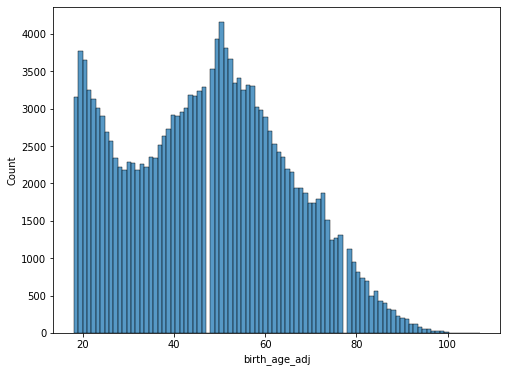

In [52]:
## Check distribution of voter age in 2020
plt.figure(figsize=(8,6))
sns.histplot(elec_df['birth_age_adj']);

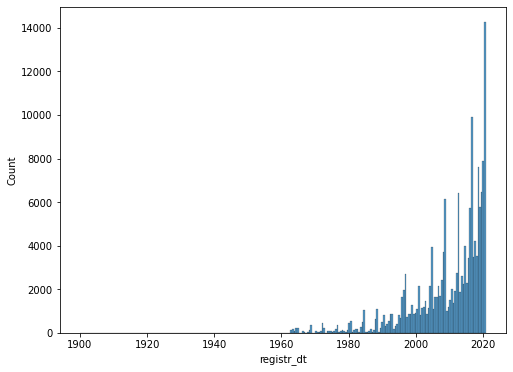

In [53]:
## Check distribution of registration dates
plt.figure(figsize=(8,6))
sns.histplot(elec_df['registr_dt']);

## Relationship to Target (Gen_2020 voting method)

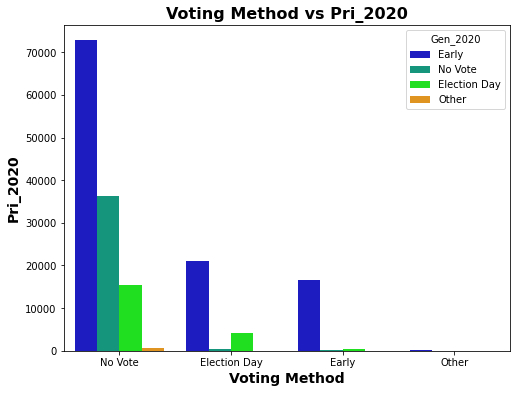

In [48]:
plot_count('Pri_2020', 'Gen_2020', elec_df);

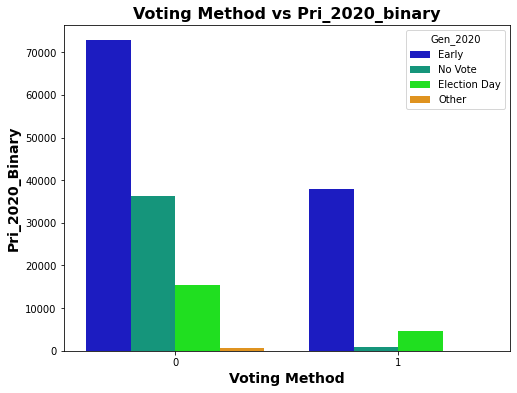

In [63]:
plot_count('Pri_2020_binary', 'Gen_2020', elec_df);

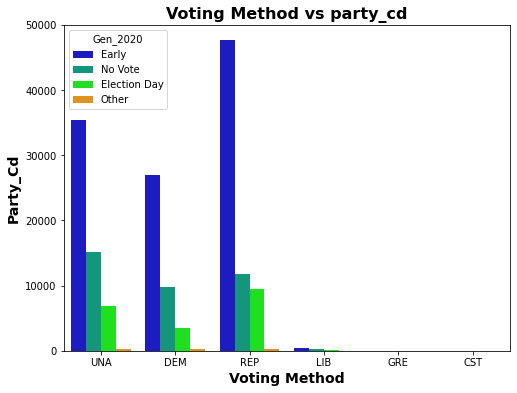

In [49]:
plot_count('party_cd', 'Gen_2020', elec_df);

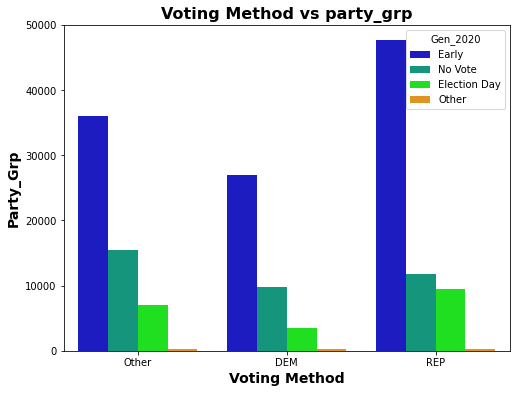

In [58]:
plot_count('party_grp', 'Gen_2020', elec_df);

# MODEL

# INTERPRET

# Conclusions/Recommendations